In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation


In [68]:
#!pip install torch torchvision torchaudio
#!pip install -U transformers
#!pip install sentencepiece

In [75]:
#from transformers import XLNetTokenizer, XLNetForSequenceClassification
#from torch.utils.data import DataLoader, TensorDataset
#import torch

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Embedding
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score

# Load Data

In [4]:
true_df = pd.read_csv('./Dataset/True.csv')
fake_df = pd.read_csv('./Dataset/Fake.csv')

In [5]:
# Create dataset
true_df['label'] = 'True'
fake_df['label'] = 'Fake'
data_df = pd.concat([true_df, fake_df], ignore_index=True)

# Clean Data

In [6]:
# Remove duplicated rows
data_df = data_df[~data_df.duplicated()]

# Remove rows with empty / short text
data_df = data_df[data_df['text'].str.len() > 10]

# Convert date string to date
data_df['date'] = pd.to_datetime(data_df['date'], errors='coerce')

# Remove rows with non-date values in 'date' column
data_df.dropna(inplace=True)
data_df.reset_index(drop=True, inplace=True)

# Preprocess Data

In [7]:
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [8]:
def preprocess_txt(txt, stem=None):
    txt = txt.lower()
    txt = re.sub('http[s]?://\S+', '', txt)
    txt = re.sub(r'[^a-z0-9_\s]+', '', txt)
    if stem == 'porter':
        token_words = word_tokenize(txt)
        stem_words = [porter.stem(word) for word in token_words]
        return ' '.join(stem_words)
    elif stem == 'lemma':
        token_words = word_tokenize(txt)
        stem_words = [lemmatizer.lemmatize(word) for word in token_words]
        return ' '.join(stem_words)
    return txt

In [9]:
for field in ['title', 'text']:
    data_df[field] = data_df[field].apply(lambda txt: preprocess_txt(txt, stem='stem'))

# Again, Remove rows with empty / short text
data_df = data_df[data_df['text'].str.len() > 10]

In [10]:
data_df.label.value_counts()

Fake    22738
True    21210
Name: label, dtype: int64

# Prepare Data set

In [11]:
def vectorize(train_data, test_data, vectorizer='count', ngram_range=(1, 1), min_df=1):
    if vectorizer == 'count':
        vector = CountVectorizer(stop_words='english', ngram_range=ngram_range, min_df=min_df)
    elif vectorizer == 'tfidf':
        vector = TfidfVectorizer(stop_words='english', ngram_range=ngram_range, min_df=min_df)

    train_data = vector.fit_transform(train_data)
    test_data = vector.transform(test_data)
    return train_data, test_data

In [13]:
X, y = data_df[['subject', 'title', 'text']].apply(' '.join, axis=1), data_df['label']
X_text_train, X_text_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=27)

# vector = CountVectorizer(stop_words='english', ngram_range=(1, 1), min_df=4)
vector = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), min_df=4)
# vector = HashingVectorizer(stop_words='english', ngram_range=(1, 1))

X_train = vector.fit_transform(X_text_train)
X_test = vector.transform(X_text_test)

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Logistic Regression

#### Hyper Parameter Tuning

In [41]:
cs_values = [10**-6,10**-4,10**-2,1]
l1_ratios = [x*0.2 for x in range(5)]

In [42]:
optimal_c,optimal_l1 = 0,0
best_score = 0
ctr = 0
for c in cs_values:
    for l1 in l1_ratios:
        tempModel =  LogisticRegression(C=c,penalty="elasticnet",l1_ratio=l1,solver='saga')
        tempModel.fit(X_train_scaled,y_train)
        mean_acc = tempModel.score(X_test_scaled,y_test)
        
        ctr+=1
        if ctr%5==0:
            print("Proceesed:",ctr)
        if mean_acc> best_score:
            best_score = mean_acc
            optimal_c = c
            optimal_l1 = l1
            
print("Optimal Values for C:",optimal_c)
print("Optimal Values for l1_ratio:",optimal_l1)

Proceesed: 5
Proceesed: 10
Proceesed: 15
Proceesed: 20
Optimal Values for C: 1
Optimal Values for l1_ratio: 0.8


#### Optimal Model

In [43]:
lrModel = LogisticRegression(C=optimal_c,penalty="elasticnet",l1_ratio=optimal_l1,solver='saga')

In [44]:
lrModel.fit(X_train_scaled,y_train)

LogisticRegression(C=1, l1_ratio=0.8, penalty='elasticnet', solver='saga')

#### Results on Test Set

In [45]:
lrModel.score(X_test_scaled,y_test)

0.9993932499051953

# Random Forest

#### Hyper Parameter Tuning

In [49]:
n_estimators= [100*x for x in range(1,6)]
max_depths = [100*x for x in range(1,6)]

In [50]:
optimal_estimator,optimal_depth = 0,0
best_score = 0
ctr = 0
for estimator in n_estimators:
    for depth in max_depths:
        tempModel =  RandomForestClassifier(max_depth=depth, n_estimators=estimator)
        tempModel.fit(X_train_scaled,y_train)
        mean_acc = tempModel.score(X_test_scaled,y_test)
        
        ctr+=1
        if ctr%5==0:
            print("Proceesed:",ctr)
        if mean_acc> best_score:
            best_score = mean_acc
            optimal_estimator = estimator
            optimal_depth = depth
            
print("Optimal Values for n_estimators:",optimal_estimator)
print("Optimal Values for max_depth:",optimal_depth)

Proceesed: 5
Proceesed: 10
Proceesed: 15
Proceesed: 20
Proceesed: 25
Optimal Values for n_estimators: 100
Optimal Values for max_depth: 500


#### Optimal Model

In [51]:
rf = RandomForestClassifier(max_depth=optimal_depth, n_estimators=optimal_estimator)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=500)

#### Results on Test Set

In [52]:
rf.score(X_test_scaled, y_test)

0.9984831247629883

# SVM

In [53]:
svc = SVC(verbose=True, tol=0.01)
svc.fit(X_train_scaled[:500], y_train[:500])

[LibSVM]

SVC(tol=0.01, verbose=True)

In [54]:
svc.score(X_test_scaled, y_test)

0.9001137656427759

# Naive Bayes Classifier


In [56]:
from sklearn.naive_bayes import MultinomialNB

In [62]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict labels for test data
y_pred = clf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(report)

Accuracy: 0.95
              precision    recall  f1-score   support

        Fake       0.96      0.94      0.95      6840
        True       0.94      0.95      0.95      6345

    accuracy                           0.95     13185
   macro avg       0.95      0.95      0.95     13185
weighted avg       0.95      0.95      0.95     13185



##### Accuracy obtained from Naive Bayes: 95%

# XLNet

In [63]:
# Load the XLNet tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)


# Encode train and test text using XLNet tokenizer
train_inputs = tokenizer(X_text_train, padding=True, truncation=True, max_length=512, return_tensors='pt')
test_inputs = tokenizer(X_text_test, padding=True, truncation=True, max_length=512, return_tensors='pt')

# Convert train and test labels to binary format
train_labels = torch.tensor([0 if label == 'Fake' else 1 for label in y_train])
test_labels = torch.tensor([0 if label == 'Fake' else 1 for label in y_test])

# Create train and test datasets
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)

# Train a XLNet model
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
model.train()
for epoch in range(3):
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluate model performance on test set
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
model.eval()
with torch.no_grad():
    all_logits = []
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_logits.append(logits.cpu().numpy())
    all_logits = np.concatenate(all_logits)
    predicted_labels = np.argmax(all_logits, axis=1)
    accuracy = np.mean(predicted_labels == test_labels.numpy())

print(f"Accuracy on test set: {accuracy:.2f}")

NameError: name 'XLNetTokenizer' is not defined

# CNN

In [ ]:
#Set hyperparameters
max_features = 10000
max_len = 200
embedding_dim = 50
num_filters = 64
filter_size = 5
dropout_rate = 0.5
batch_size = 32
epochs = 3

# Generate some example data
texts = list(X_text_train)

# Tokenize the text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad the sequences
x_train = pad_sequences(sequences, maxlen=max_len)

# Convert labels to one-hot encoding
labels = list(y_train)
labels_index = {'True': 0, 'Fake': 1}
y_train = np.zeros((len(labels), 2))
for i, label in enumerate(labels):
    y_train[i, labels_index[label]] = 1

# Build the CNN model
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_len))
model.add(Conv1D(num_filters, filter_size, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(num_filters, filter_size, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dropout(dropout_rate))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

# Test the model
test_texts = list(X_text_test)
test_sequences = tokenizer.texts_to_sequences(test_texts)
x_test = pad_sequences(test_sequences, maxlen=max_len)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_c = []
for i in y_test:
  if i=="True":
    y_test_c.append(0)
  else:
    y_test_c.append(1)

accuracy = accuracy_score(y_test_c, y_pred)
print('Accuracy:', accuracy)

Epoch 1/3
962/962 [==============================] - 17s 16ms/step - loss: 0.1114 - accuracy: 0.9470
Epoch 2/3
962/962 [==============================] - 15s 16ms/step - loss: 0.0144 - accuracy: 0.9951
Epoch 3/3
883/962 [==========================>...] - ETA: 1s - loss: 0.0101 - accuracy: 0.9967

# Latent Semantic Analysis

In [17]:
lsa = TruncatedSVD(n_components=100)
X_train_scaled_lsa = lsa.fit_transform(X_train_scaled)

Top 5 words in Top 10 topics:


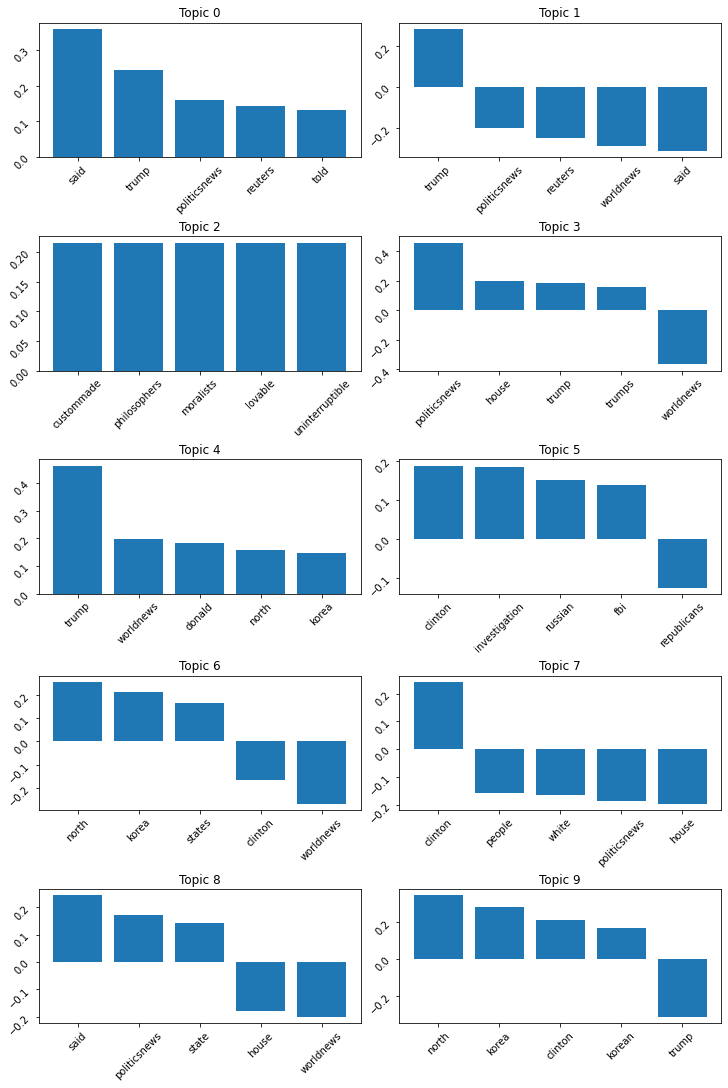

In [18]:
fig, axs = plt.subplots(5, 2, figsize=(10, 15), layout='constrained')

print('Top 5 words in Top 10 topics:')
words = vector.get_feature_names_out()
for i in range(10):
    words_comp_ls = zip(words, list(lsa.components_[i]))
    words_comp_ls = sorted(words_comp_ls, key=lambda x: abs(x[1]), reverse=True)
    
    plot_words_comp_ls = sorted(words_comp_ls[:5], key=lambda x: (x[1]), reverse=True)
    plot_words_comp_ls = [[w for w, v in plot_words_comp_ls], [v for w, v in plot_words_comp_ls]]
    idx_x, idx_y = int(i / 2), i % 2
    axs[idx_x, idx_y].bar(plot_words_comp_ls[0][:5], plot_words_comp_ls[1][:5])
    axs[idx_x, idx_y].set_title('Topic '+ str(i))
    axs[idx_x, idx_y].tick_params(labelrotation=45)
plt.show()

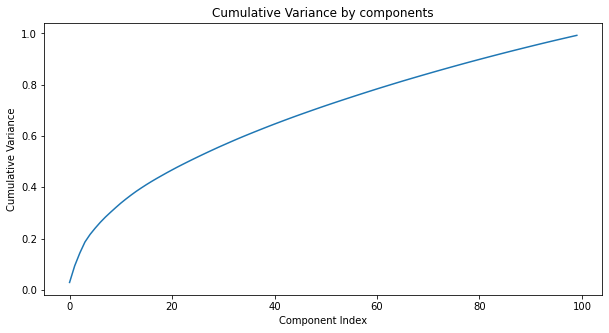

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(lsa.explained_variance_)), np.cumsum(lsa.explained_variance_))
plt.title('Cumulative Variance by components')
plt.xlabel('Component Index')
plt.ylabel('Cumulative Variance')
plt.show()

# Non-Matrix Factorization

In [26]:
nmf = NMF(n_components=100, verbose=10, tol=0.01)
X_train_scaled_nmf = nmf.fit_transform(X_train_scaled)

violation: 1.0
violation: 0.34031705338556373
violation: 0.2808384929906728
violation: 0.2199384065254517
violation: 0.1760078209531852
violation: 0.14073613724874393
violation: 0.11052660106291506
violation: 0.08965894692982342
violation: 0.07672153149376142
violation: 0.06707008598678904
violation: 0.05715723609597824
violation: 0.047244742716637575
violation: 0.03919415917202114
violation: 0.03246316948190255
violation: 0.026748651637817537
violation: 0.022330392222006636
violation: 0.01923536051112347
violation: 0.017020624955809274
violation: 0.015520452676221968
violation: 0.014459749809559724
violation: 0.013684411463724743
violation: 0.012988927668418453
violation: 0.012327227118429146
violation: 0.011705619322789655
violation: 0.010980045314130443
violation: 0.010249959268263512
violation: 0.009537271516593337
Converged at iteration 28


Top 5 words in Top 10 topics:


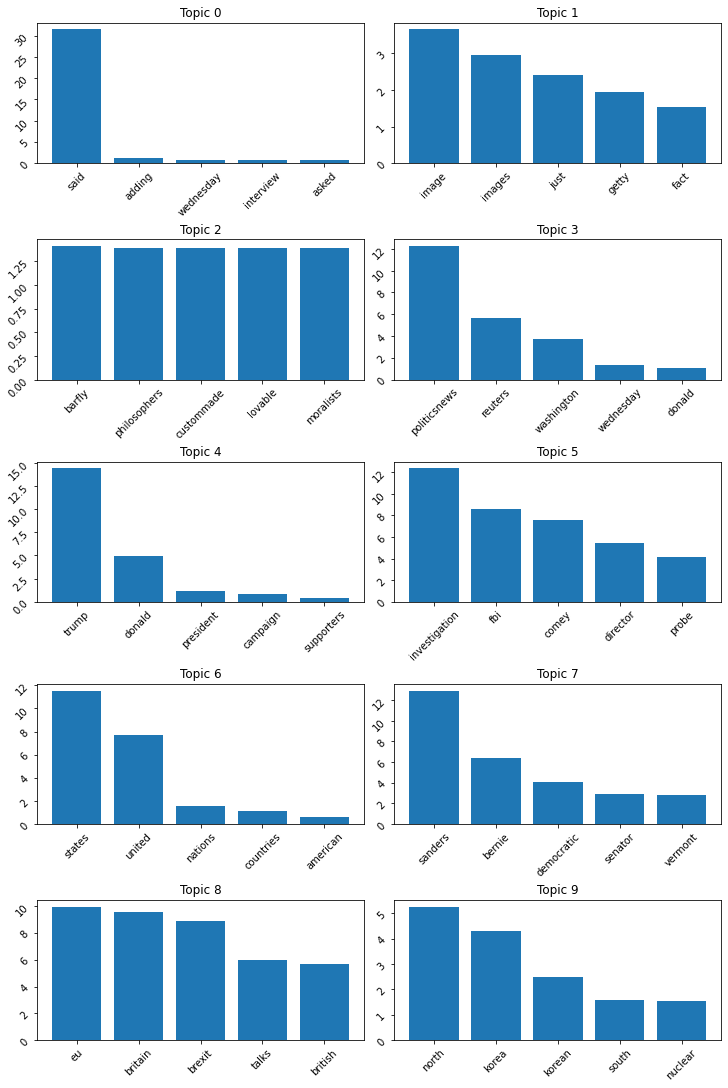

In [27]:
fig, axs = plt.subplots(5, 2, figsize=(10, 15), layout='constrained')

print('Top 5 words in Top 10 topics:')
words = vector.get_feature_names_out()
for i in range(10):
    words_comp_ls = zip(words, list(nmf.components_[i]))
    words_comp_ls = sorted(words_comp_ls, key=lambda x: abs(x[1]), reverse=True)
    
    plot_words_comp_ls = sorted(words_comp_ls[:5], key=lambda x: (x[1]), reverse=True)
    plot_words_comp_ls = [[w for w, v in plot_words_comp_ls], [v for w, v in plot_words_comp_ls]]
    idx_x, idx_y = int(i / 2), i % 2
    axs[idx_x, idx_y].bar(plot_words_comp_ls[0][:5], plot_words_comp_ls[1][:5])
    axs[idx_x, idx_y].set_title('Topic '+ str(i))
    axs[idx_x, idx_y].tick_params(labelrotation=45)
plt.show()

# Latent Dirichlet Allocation

In [22]:
lda = LatentDirichletAllocation(n_components=10, learning_method='batch')
X_train_scaled_lda = lda.fit_transform(X_train_scaled)

Top 5 words in Top 10 topics:


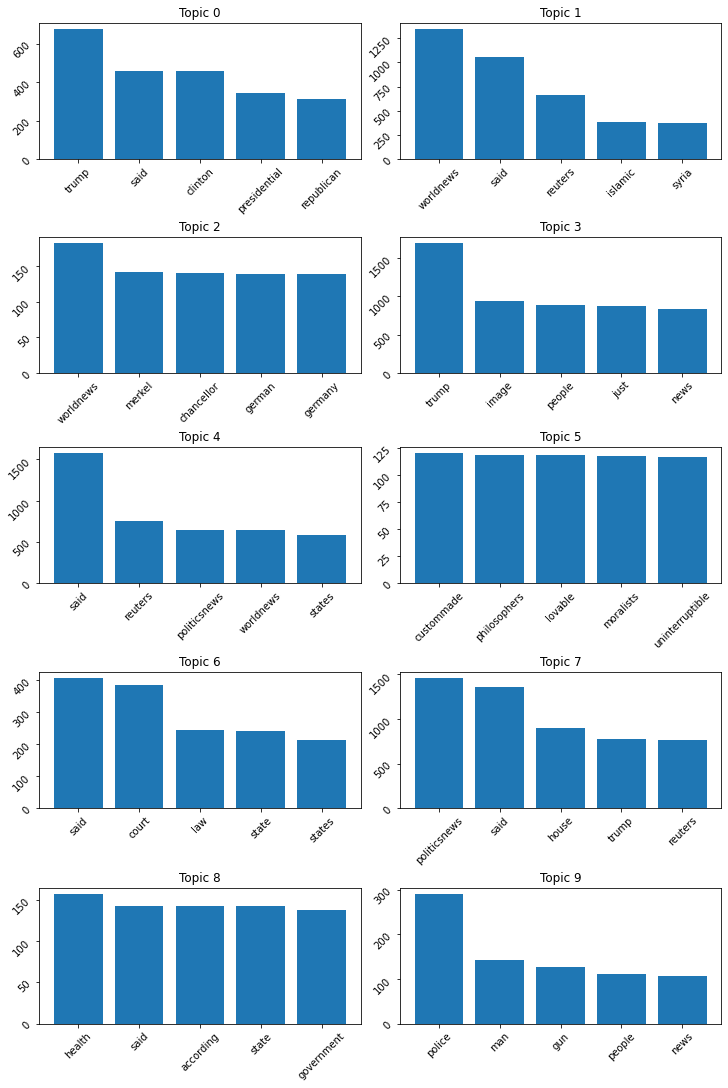

In [23]:
fig, axs = plt.subplots(5, 2, figsize=(10, 15), layout='constrained')

print('Top 5 words in Top 10 topics:')
words = vector.get_feature_names_out()
for i in range(10):
    words_comp_ls = zip(words, list(lda.components_[i]))
    words_comp_ls = sorted(words_comp_ls, key=lambda x: abs(x[1]), reverse=True)
    
    plot_words_comp_ls = sorted(words_comp_ls[:5], key=lambda x: (x[1]), reverse=True)
    plot_words_comp_ls = [[w for w, v in plot_words_comp_ls], [v for w, v in plot_words_comp_ls]]
    idx_x, idx_y = int(i / 2), i % 2
    axs[idx_x, idx_y].bar(plot_words_comp_ls[0][:5], plot_words_comp_ls[1][:5])
    axs[idx_x, idx_y].set_title('Topic '+ str(i))
    axs[idx_x, idx_y].tick_params(labelrotation=45)
plt.show()

## BERT Model

In [17]:
#!pip install tensorflow_hub --user
#!pip install tensorflow-text

In [44]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [45]:
X, y = data_df[['subject', 'title', 'text']].apply(' '.join, axis=1), data_df['label']
y, categories = pd.factorize(y)

In [46]:
categories

Index(['True', 'Fake'], dtype='object')

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 27)

In [48]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

### Building the Neural Network

In [49]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [50]:
out = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
out = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(out)

In [51]:
model = tf.keras.Model(inputs=[text_input], outputs = [out])

In [52]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [53]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

In [54]:
history = model.fit(X_train, y_train, epochs=20)

Epoch 1/20
962/962 [==============================] - 561s 564ms/step - loss: 0.3805 - accuracy: 0.8515 - precision: 0.8524 - recall: 0.8622
Epoch 2/20
962/962 [==============================] - 564s 586ms/step - loss: 0.2470 - accuracy: 0.9076 - precision: 0.9079 - recall: 0.9141
Epoch 3/20
962/962 [==============================] - 564s 587ms/step - loss: 0.2218 - accuracy: 0.9161 - precision: 0.9160 - recall: 0.9224
Epoch 4/20
962/962 [==============================] - 560s 582ms/step - loss: 0.2092 - accuracy: 0.9188 - precision: 0.9196 - recall: 0.9238
Epoch 5/20
962/962 [==============================] - 562s 584ms/step - loss: 0.2013 - accuracy: 0.9217 - precision: 0.9215 - recall: 0.9276
Epoch 6/20
962/962 [==============================] - 558s 580ms/step - loss: 0.1953 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9292
Epoch 7/20
962/962 [==============================] - 556s 578ms/step - loss: 0.1906 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9309
Epoch 8/20
96

In [55]:
acc = history.history['accuracy']
loss = history.history['loss']

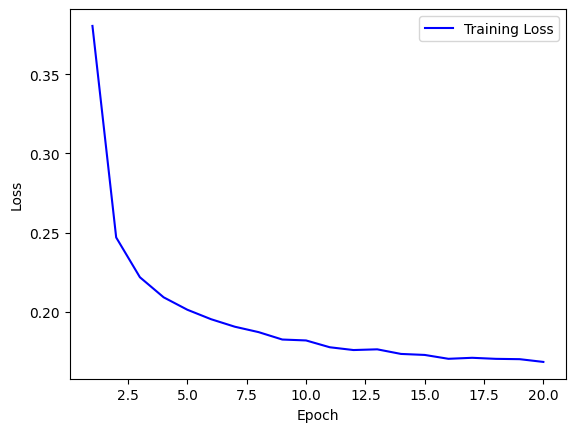

In [57]:
# Create count of the number of epochs
epoch_count = [i for i in range(1,21)]
# Visualize loss history
plt.plot(epoch_count, loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [58]:
y_pred = model.predict(X_test)
y_pred_label = y_pred >= 0.5

413/413 [==============================] - 230s 552ms/step


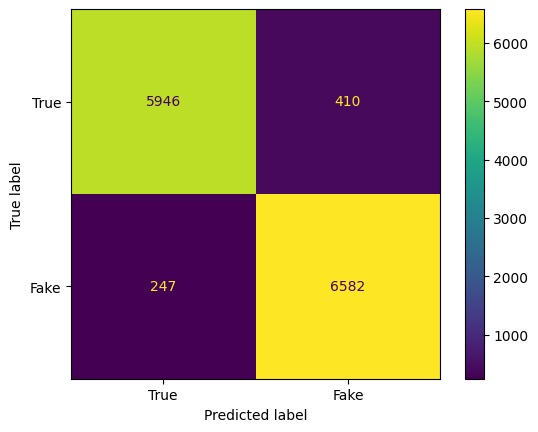

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusionMatrix = confusion_matrix(y_test, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix,display_labels=categories)
disp.plot()

In [60]:
from sklearn.metrics import precision_recall_fscore_support
metrics  = precision_recall_fscore_support(y_test, y_pred_label, average='macro')
print("Macro Precsion on Test Set:",metrics[0])
print("Macro Recall on Test Set:",metrics[1])
print("Macro F1 Score on Test Set:",metrics[2])

Macro Precsion on Test Set: 0.9507389081789768
Macro Recall on Test Set: 0.9496623716591617
Macro F1 Score on Test Set: 0.9500544364895773


### Word2vec models

#### Using custom embeddings

In [81]:
X, y = data_df[['subject', 'title', 'text']].apply(' '.join, axis=1), data_df['label']
y, categories = pd.factorize(y)

In [82]:
# Preprocessing the inputs to the form for creating the embedding
X_processed = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for text in X:
    temp = []
    sentences = nltk.sent_tokenize(text)
    for sent in sentences:
        tokens = tokenizer.tokenize(sent)
        filtered_words = [word.strip() for word in tokens if word not in stop_words and len(word) > 1] # removing stop words and words of single letter 
        temp.extend(filtered_words)
    X_processed.append(temp)


In [83]:
import gensim
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
word2vec_model = gensim.models.Word2Vec(sentences=X_processed, vector_size=EMBEDDING_DIM, window=5, min_count=1)

In [84]:
print("Vocabulary Size:",len(word2vec_model.wv))

Vocabulary Size: 227718


In [85]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.metrics import classification_report

In [86]:
MAX_SEQUENCE_LENGTH = 1000 # Justifed by the EDA on text length
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# word_index = tokenizer.word_index
X_transformed = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


In [90]:
X_train,X_test,y_train, y_test = train_test_split(X_transformed, y, test_size=0.3,random_state = 27)

In [92]:
vocab_size = len(tokenizer.word_index) + 1

In [94]:
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [96]:
embedding_layer = gensim_to_keras_embedding(word2vec_model)

In [98]:
word2vec_clf_Model = Sequential()
word2vec_clf_Model.add(embedding_layer)
word2vec_clf_Model.add(LSTM(units=128))
word2vec_clf_Model.add(Dense(1,activation="sigmoid"))

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

word2vec_clf_Model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [99]:
word2vec_clf_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         22771800  
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22,889,177
Trainable params: 117,377
Non-trainable params: 22,771,800
_________________________________________________________________


In [100]:
history = word2vec_clf_Model.fit(X_train, y_train, epochs=10)

Epoch 1/10
962/962 [==============================] - 117s 109ms/step - loss: 0.2627 - accuracy: 0.8863 - precision: 0.9188 - recall: 0.8556
Epoch 2/10
962/962 [==============================] - 105s 109ms/step - loss: 0.0407 - accuracy: 0.9878 - precision: 0.9842 - recall: 0.9924
Epoch 3/10
962/962 [==============================] - 105s 109ms/step - loss: 0.0123 - accuracy: 0.9959 - precision: 0.9958 - recall: 0.9963
Epoch 4/10
962/962 [==============================] - 109s 113ms/step - loss: 0.0042 - accuracy: 0.9983 - precision: 0.9984 - recall: 0.9984
Epoch 5/10
962/962 [==============================] - 107s 111ms/step - loss: 0.0018 - accuracy: 0.9995 - precision: 0.9994 - recall: 0.9996
Epoch 6/10
962/962 [==============================] - 107s 111ms/step - loss: 0.0066 - accuracy: 0.9980 - precision: 0.9981 - recall: 0.9981
Epoch 7/10
962/962 [==============================] - 108s 112ms/step - loss: 0.0018 - accuracy: 0.9994 - precision: 0.9997 - recall: 0.9992
Epoch 8/10
96

In [101]:
acc = history.history['accuracy']
loss = history.history['loss']

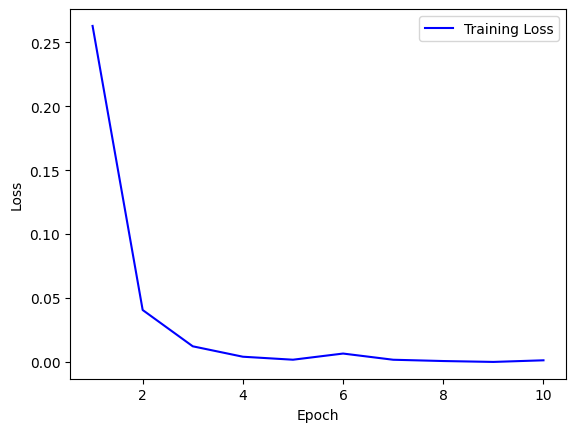

In [103]:
# Create count of the number of epochs
epoch_count = [i for i in range(1,11)]
# Visualize loss history
plt.plot(epoch_count, loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [105]:
y_pred = word2vec_clf_Model.predict(X_test)
y_pred_label = y_pred >= 0.5

413/413 [==============================] - 16s 37ms/step


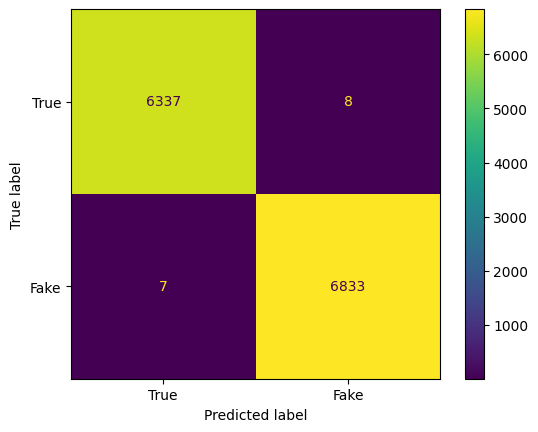

In [106]:
confusionMatrix = confusion_matrix(y_test, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix,display_labels=categories)
disp.plot()

In [108]:
metrics  = precision_recall_fscore_support(y_test, y_pred_label, average='macro')
print("Macro Precsion on Test Set:",metrics[0])
print("Macro Recall on Test Set:",metrics[1])
print("Macro F1 Score on Test Set:",metrics[2])

Macro Precsion on Test Set: 0.9988635877662924
Macro Recall on Test Set: 0.998857886441873
Macro F1 Score on Test Set: 0.9988607313339275
